In [49]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist, cifar10

from tensorflow.keras.layers import (Activation, BatchNormalization, Concatenate, Dense,
                                     Dropout, Flatten, Input, Lambda, Reshape)
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [2]:
import tensorflow as tf
gpu_num = 3
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU만 사용하도록 제한
  try:
    tf.config.experimental.set_visible_devices(gpus[gpu_num], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
  except RuntimeError as e:
    # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
    print(e)
    
from tensorflow.keras.mixed_precision.experimental import Policy
policy = Policy('mixed_float16')
tf.keras.mixed_precision.experimental.set_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale
Compute dtype: float16
Variable dtype: float32


In [3]:
# 주요 변수 정의하기
original_dim = 784
latent_dim = 8
intermediate_dim = 256
epsilon_std = 1.0

img_rows = 28
img_cols = 28
#img_rows = 32
#img_cols = 32


channels = 1

# 입력 이미지 차원
img_shape = (img_rows, img_cols, channels)

# 생성자의 입력으로 사용할 잡음 벡터의 크기
z_dim = latent_dim

# 데이터셋에 있는 클래스 개수
num_classes = 10


num_labeled = 50
num_data = 5000

In [4]:
class Dataset:
    def __init__(self, num_labeled, num_data=10000):
        self.n_row = 28
        self.n_col = 28

        # 훈련에 사용할 레이블된 샘플 개수
        self.num_labeled = num_labeled
        self.num_data    = num_data

        # MNIST 데이터셋 적재
        (self.x_train, self.y_train), (self.x_test,self.y_test) = mnist.load_data()
        #(self.x_train, self.y_train), (self.x_test,self.y_test) = cifar10.load_data()

        def preprocess_imgs(x):
            # [0, 255] 사이 흑백 픽셀 값을 [–1, 1] 사이로 변환
            #x = (x.astype(np.float32) - 127.5) / 127.5
            x = x.astype(np.float32) / 255.
            # 너비 × 높이 × 채널로 이미지 차원을 확장
            #x = np.expand_dims(x, axis=3)
            x = np.reshape(x, (-1,img_rows, img_cols, channels))
            return x

        def preprocess_labels(y):
            return y.reshape(-1, 1)

        # 훈련 데이터
        self.x_train = preprocess_imgs(self.x_train[:self.num_data])
        self.y_train = preprocess_labels(self.y_train[:self.num_data])

        # 테스트 데이터
        self.x_test = preprocess_imgs(self.x_test)
        self.y_test = preprocess_labels(self.y_test)

    def batch_labeled(self, batch_size):
        # 레이블된 이미지와 레이블의 랜덤 배치 만들기
        idx = np.random.randint(0, self.num_labeled, batch_size)
        imgs = self.x_train[idx]
        labels = self.y_train[idx]
        return imgs, labels

    def batch_unlabeled(self, batch_size):
        # 레이블이 없는 이미지의 랜덤 배치 만들기
        idx = np.random.randint(self.num_labeled, self.x_train.shape[0],
                                batch_size)
        imgs = self.x_train[idx]
        return imgs

    def training_set(self):
        x_train = self.x_train[range(self.num_labeled)]
        y_train = self.y_train[range(self.num_labeled)]
        return x_train, y_train

    def test_set(self):
        return self.x_test, self.y_test
    
    def VAE_training_set(self):
        # reshape(-1,28*28)
        # 1D
        x_train = self.x_train
        #x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
        y_train = self.y_train
        return x_train, y_train

    def VAE_test_set(self):
        # reshape(-1,28*28)
        # 1D
        x_test = self.x_test
        #x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
        return x_test, self.y_test

In [5]:
# 인코더 입력 - 28 28 1
def build_encoder(img_shape):
    def sampling(args: tuple):
        # 튜플로 매개변수를 감쌉니다.
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                                  stddev=epsilon_std, dtype='float16')
        return z_mean + K.exp(z_log_var / 2) * epsilon

    #model = Sequential()
    x = Input(shape=(img_shape), name="input")

    # 28 × 28 × 1에서 14 × 14 × 32 텐서로 바꾸는 합성곱 층
    conv1 = Conv2D(32, kernel_size=3, strides=2,
                   activation = LeakyReLU(alpha=0.01),
                   padding='same')(x)

    # LeakyReLU 활성화 함수
    #model.add(LeakyReLU(alpha=0.01))

    # 14 × 14 × 32에서 7 × 7 × 32 텐서로 바꾸는 합성곱 층
    conv2 = Conv2D(64, kernel_size=3, strides=2,
                   activation = LeakyReLU(alpha=0.01),
                   padding='same')(conv1)
    
    # LeakyReLU 활성화 함수
    #model.add(LeakyReLU(alpha=0.01))

    # 7 × 7 × 64에서 4 × 4 × 16 텐서로 바꾸는 합성곱 층
    #conv3 = Conv2D(128, kernel_size=3, strides=2,
    #               activation = LeakyReLU(alpha=0.01),
    #               padding='valid')(conv2)
    
    # LeakyReLU 활성화 함수
    #model.add(LeakyReLU(alpha=0.01))

    # 드롭아웃
    #conv3_drop = Dropout(0.5)(conv3)

    # 텐서 펼치기
    conv_F = Flatten()(conv2)

    h = Dense(32, activation=LeakyReLU(alpha=0.01), name="encoding")(conv_F)
    
    
    # 잠재 공간의 평균을 정의합니다.
    _z_mean = Dense(latent_dim, name="mean")(h)
    z_mean = Activation('linear',dtype='float32')(_z_mean)
    # 잠재 공간의 로그 분산을 정의합니다.
    _z_log_var = Dense(latent_dim, name="log-variance")(h)
    z_log_var = Activation('linear',dtype='float32')(_z_log_var)
    # 텐서플로 백엔드를 사용할 때는 output_shape이 꼭 필요한 것은 아닙니다.
    _z = Lambda(sampling, output_shape=(latent_dim,))([_z_mean, _z_log_var])
    z = Activation('linear',dtype='float32')(_z)
    
    encoder = Model(x, [z_mean, z_log_var, z], name="encoder")


    return encoder

In [6]:
encoder_tmp = build_encoder(img_shape)
encoder_tmp.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [7]:
# Decoder - conv net
def build_decoder(latent_dim):

    input_decoder = Input(shape=(latent_dim), name="input")

    # 완전 연결 층을 사용해 입력을 3 × 3 × 32 크기 텐서로 바꿉니다.
    de_dense = Dense(7*7*64)(input_decoder)
    de_reshape = Reshape((7,7,64))(de_dense)
    #de_dense = Dense(8*8*64)(input_decoder)
    #de_reshape = Reshape((8,8,64))(de_dense)
    # 완전 연결 층을 사용해 입력을 4 × 4 × 16 크기 텐서로 바꿉니다.

    # 4 × 4 × 256에서 8 × 8 × 128 텐서로 바꾸는 전치 합성곱 층
    de_conv1 = Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(de_reshape)
    de_conv1_bn = BatchNormalization()(de_conv1)
    de_conv1_act = LeakyReLU(alpha=0.01)(de_conv1_bn)
    
    de_conv2 = Conv2DTranspose(32, kernel_size=3, strides=2, padding='same')(de_conv1_act)
    de_conv2_bn = BatchNormalization()(de_conv2)
    de_conv2_act = LeakyReLU(alpha=0.01)(de_conv2_bn)
    
    de_conv3 = Conv2DTranspose(channels, kernel_size=3, strides=1, padding='same')(de_conv2_act)
    de_conv3_act = Activation('sigmoid')(de_conv3)
    
    x_decoded = Activation('linear', dtype='float32')(de_conv3_act)

    decoder = Model(input_decoder, x_decoded, name="decoder")
    
    return decoder

In [8]:
# VAE encoder
VAE_encoder = build_encoder(img_shape)

# VAE decoder
VAE_decoder = build_decoder(latent_dim)

# VAE
VAE_input = Input(shape=(img_shape), name="VAE_input")
VAE_z_mean , VAE_z_log_var, VAE_z = VAE_encoder(VAE_input)
VAE_output = VAE_decoder(VAE_z)

kl_loss = -0.5 * K.sum(
    1 + VAE_z_log_var - K.exp(VAE_z_log_var) - K.square(VAE_z_mean),
    axis=-1)

VAE = Model(VAE_input,VAE_output)

VAE.add_loss(K.mean(kl_loss) / 784.)


optimizer_func = Adam(learning_rate=0.001)

VAE.compile(optimizer=optimizer_func, loss="binary_crossentropy")


VAE.summary()


  opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
VAE_input (InputLayer)          [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 8), (None, 8 119728      VAE_input[0][0]                  
__________________________________________________________________________________________________
decoder (Functional)            (None, 28, 28, 1)    84289       encoder[0][2]                    
__________________________________________________________________________________________________
tf.__operators__.add (TFOpLambd (None, 8)            0           encoder[0][1]                    
_______________________

In [9]:
# 사용할 레이블된 샘플 개수 (나머지는 레이블없이 사용합니다)


dataset = Dataset(num_labeled,  num_data)

In [10]:
VAE_x_train, VAE_y_train = dataset.VAE_training_set()
VAE_x_test , VAE_y_test  = dataset.VAE_test_set()

In [11]:
# 주요 변수 정의하기
VAE_batch_size = 100
VAE_epochs = 40

In [12]:
VAE.fit(VAE_x_train, VAE_x_train,
        shuffle=True,
        epochs=VAE_epochs,
        batch_size=VAE_batch_size)

Epoch 1/40
50/50 [==============================] - 4s 12ms/step - loss: 0.3823
Epoch 2/40
50/50 [==============================] - 1s 11ms/step - loss: 0.2245
Epoch 3/40
50/50 [==============================] - 1s 11ms/step - loss: 0.1881
Epoch 4/40
50/50 [==============================] - 1s 10ms/step - loss: 0.1757
Epoch 5/40
50/50 [==============================] - 1s 12ms/step - loss: 0.1655
Epoch 6/40
50/50 [==============================] - 1s 11ms/step - loss: 0.1621
Epoch 7/40
50/50 [==============================] - 1s 11ms/step - loss: 0.1568
Epoch 8/40
50/50 [==============================] - 1s 11ms/step - loss: 0.1545
Epoch 9/40
50/50 [==============================] - 1s 11ms/step - loss: 0.1524
Epoch 10/40
50/50 [==============================] - 1s 11ms/step - loss: 0.1499
Epoch 11/40
50/50 [==============================] - 1s 11ms/step - loss: 0.1493
Epoch 12/40
50/50 [==============================] - 1s 11ms/step - loss: 0.1467
Epoch 13/40
50/50 [==================

## Build generator

In [13]:
def build_generator(VAE_decoder):
    model = Sequential()
    model.add(VAE_decoder)

    return model

## Build discriminator

In [14]:
def build_discriminator_net(img_shape):

    model = Sequential()

    # 28 × 28 × 1에서 14 × 14 × 32 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(32,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.1))
    #model.add(Activation('sigmoid'))

    # 14 × 14 × 32에서 7 × 7 × 64 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))
    
    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.1))
    #model.add(Activation('sigmoid'))

    # 7 × 7 × 64에서 3 × 3 × 128 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))
    
    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.1))
    #model.add(Activation('sigmoid'))

    # 드롭아웃
    model.add(Dropout(0.5))

    # 텐서 펼치기
    model.add(Flatten())
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.5))
    #model.add(Activation('sigmoid'))

    # num_classes 개의 뉴런을 가진 완전 연결 층
    model.add(Dense(num_classes))

    return model

In [15]:
def build_discriminator_supervised(discriminator_net):

    model = Sequential()

    model.add(discriminator_net)

    # 진짜 클래스에 대한 예측 확률을 출력하는 소프트맥스 활성화 함수
    model.add(Activation('softmax', dtype='float32'))

    return model

In [16]:
def build_discriminator_unsupervised(discriminator_net):

    model = Sequential()

    model.add(discriminator_net)

    def predict(x):
        # 진짜 클래스에 대한 확률 분포를 진짜 대 가짜의 이진 확률로 변환합니다.
        prediction = 1.0 - (1.0 /(K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))
        #prediction = K.sum(x, axis=-1, keepdims=True)
        return prediction

    # 앞서 정의한 진짜 대 가짜 확률을 출력하는 뉴런
    model.add(Lambda(predict))
    #model.add(Activation('sigmoid'))
    model.add(Activation('linear',dtype='float32'))

    return model

## Model define

In [17]:
def build_gan(generator, discriminator):

    model = Sequential()

    # 생성자와 판별자 모델을 연결하기
    model.add(generator)
    model.add(discriminator)

    return model

In [18]:
# 판별자 기반 모델: 이 층들은 지도 학습 훈련과 비지도 학습 훈련에 공유됩니다.
discriminator_net = build_discriminator_net(img_shape)

# 지도 학습 훈련을 위해 판별자를 만들고 컴파일합니다.
discriminator_supervised = build_discriminator_supervised(discriminator_net)
#discriminator_supervised.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=Adam(learning_rate=0.0004))
discriminator_supervised.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=Adam(learning_rate=0.0004))

# 비지도 학습 훈련을 위해 판별자를 만들고 컴파일합니다.
discriminator_unsupervised = build_discriminator_unsupervised(discriminator_net)
#discriminator_unsupervised.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.0008))
discriminator_unsupervised.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.0008))

  opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt)

  opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt)



In [19]:
# 생성자를 만듭니다.
generator = build_generator(VAE_decoder)

# 생성자 훈련을 위해 판별자의 모델 파라미터를 동결합니다.
discriminator_unsupervised.trainable = False

# 생성자를 훈련하기 위해 고정된 판별자로 GAN 모델을 만들고 컴파일합니다.
# 노트: 비지도 학습용 판별자를 사용하세요.
gan = build_gan(generator, discriminator_unsupervised)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=4e-5))

  opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt)



In [20]:
gan.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 28, 28, 1)         84289     
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1146890   
Total params: 1,231,179
Trainable params: 84,097
Non-trainable params: 1,147,082
_________________________________________________________________


## Train

In [21]:
supervised_losses = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # 진짜 이미지의 레이블: 모두 1
    real = np.ones((batch_size, 1))

    # 가짜 이미지의 레이블: 모두 0
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  판별자 훈련
        # -------------------------

        # 레이블된 샘플을 가져옵니다.
        imgs, labels = dataset.batch_labeled(batch_size)

        # 레이블을 원-핫 인코딩합니다.
        labels = to_categorical(labels, num_classes=num_classes)

        # 레이블이 없는 샘플을 가져옵니다.
        imgs_unlabeled = dataset.batch_unlabeled(batch_size)

        # 가짜 이미지의 배치를 생성합니다.
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)

        # 레이블된 진짜 샘플에서 훈련합니다.
        d_loss_supervised, accuracy = discriminator_supervised.train_on_batch(imgs, labels)

        # 레이블이 없는 진짜 샘플에서 훈련합니다.
        d_loss_real = discriminator_unsupervised.train_on_batch(imgs_unlabeled, real)

        # 가짜 샘플에서 훈련합니다.
        d_loss_fake = discriminator_unsupervised.train_on_batch(gen_imgs, fake)

        d_loss_unsupervised = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  생성자 훈련
        # ---------------------

        # 가짜 이미지의 배치를 생성합니다.
        #z = np.random.normal(0, 1, (batch_size, z_dim))
        #gen_imgs = generator.predict(z)

        # 생성자를 훈련합니다.
        g_loss = gan.train_on_batch(z, np.ones((batch_size, 1)))

        if (iteration + 1) % sample_interval == 0:

            # 훈련이 끝난 후 그래프를 그리기 위해 판별자의 지도 학습 분류 손실을 기록합니다.
            supervised_losses.append(d_loss_supervised)
            iteration_checkpoints.append(iteration + 1)

            # 훈련 과정을 출력합니다.
            print(
                "%d [D loss supervised: %.4f, acc.: %.2f%%] [D loss unsupervised: %.4f] [G loss: %f]"
                % (iteration + 1, d_loss_supervised, 100 * accuracy,
                   d_loss_unsupervised, g_loss))
            sample_images(generator)

In [22]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # 랜덤한 잡음 샘플링
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # 랜덤한 잡음에서 이미지 생성하기
    gen_imgs = generator.predict(z)

    # 이미지 픽셀 값을 [0, 1] 사이로 스케일 조정
    #gen_imgs = 0.5 * gen_imgs + 0.5

    # 이미지 그리드 설정
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # 이미지 그리드 출력
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            #axs[i, j].imshow(gen_imgs[cnt, :, :, :], cmap='rgb')
            #axs[i, j].imshow(gen_imgs[cnt, :, :, :])
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

100 [D loss supervised: 0.3579, acc.: 92.00%] [D loss unsupervised: 0.4791] [G loss: 1.367054]


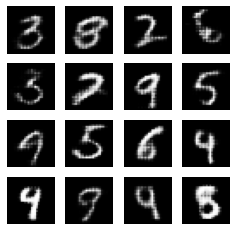

200 [D loss supervised: 0.1129, acc.: 100.00%] [D loss unsupervised: 0.4609] [G loss: 1.720977]


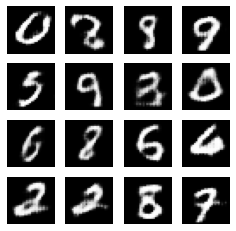

300 [D loss supervised: 0.0846, acc.: 100.00%] [D loss unsupervised: 0.5086] [G loss: 1.130783]


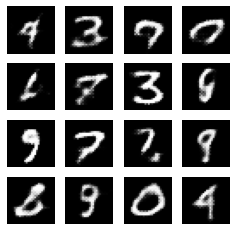

400 [D loss supervised: 0.0297, acc.: 100.00%] [D loss unsupervised: 0.5679] [G loss: 1.729005]


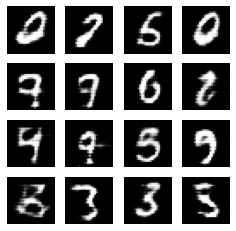

500 [D loss supervised: 0.0330, acc.: 100.00%] [D loss unsupervised: 0.8084] [G loss: 0.920939]


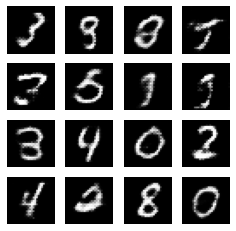

600 [D loss supervised: 0.0166, acc.: 100.00%] [D loss unsupervised: 0.4197] [G loss: 2.931921]


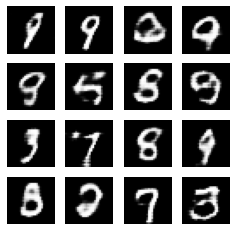

700 [D loss supervised: 0.0194, acc.: 100.00%] [D loss unsupervised: 0.6217] [G loss: 1.294792]


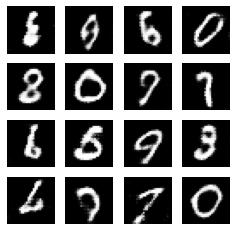

800 [D loss supervised: 0.0042, acc.: 100.00%] [D loss unsupervised: 0.3674] [G loss: 2.129336]


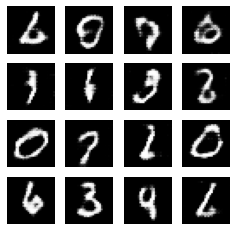

900 [D loss supervised: 0.0079, acc.: 100.00%] [D loss unsupervised: 0.5149] [G loss: 1.159666]


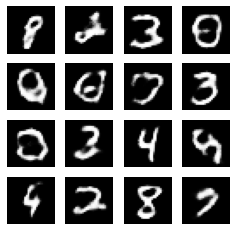

1000 [D loss supervised: 0.0078, acc.: 100.00%] [D loss unsupervised: 0.4511] [G loss: 1.988765]


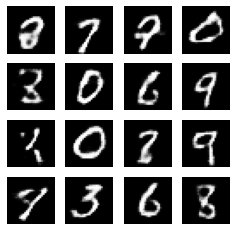

1100 [D loss supervised: 0.0126, acc.: 100.00%] [D loss unsupervised: 0.4807] [G loss: 1.296480]


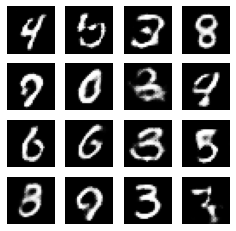

1200 [D loss supervised: 0.0156, acc.: 100.00%] [D loss unsupervised: 0.5659] [G loss: 1.748197]


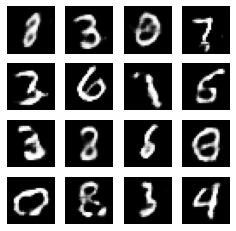

1300 [D loss supervised: 0.0051, acc.: 100.00%] [D loss unsupervised: 0.4349] [G loss: 1.721728]


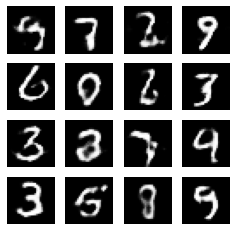

1400 [D loss supervised: 0.0131, acc.: 100.00%] [D loss unsupervised: 0.5282] [G loss: 1.933396]


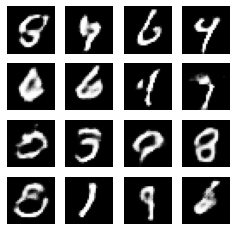

1500 [D loss supervised: 0.0017, acc.: 100.00%] [D loss unsupervised: 0.4073] [G loss: 1.605589]


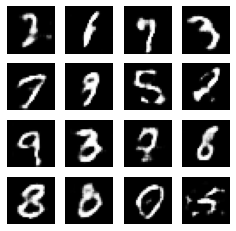

1600 [D loss supervised: 0.0068, acc.: 100.00%] [D loss unsupervised: 0.3891] [G loss: 1.960769]


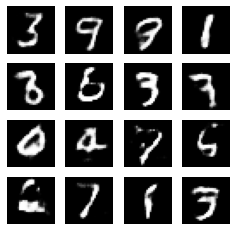

1700 [D loss supervised: 0.0017, acc.: 100.00%] [D loss unsupervised: 0.6188] [G loss: 1.642978]


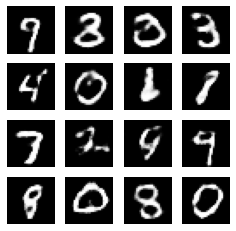

1800 [D loss supervised: 0.0019, acc.: 100.00%] [D loss unsupervised: 0.6985] [G loss: 1.741312]


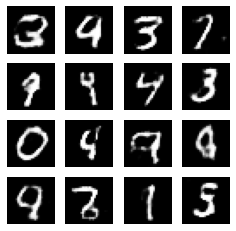

1900 [D loss supervised: 0.0027, acc.: 100.00%] [D loss unsupervised: 0.6184] [G loss: 1.245984]


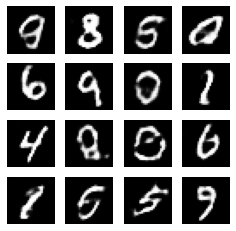

2000 [D loss supervised: 0.0049, acc.: 100.00%] [D loss unsupervised: 0.6862] [G loss: 1.653256]


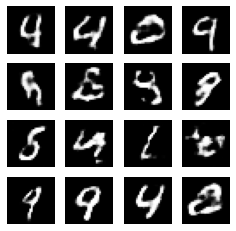

2100 [D loss supervised: 0.0072, acc.: 100.00%] [D loss unsupervised: 0.6146] [G loss: 2.107442]


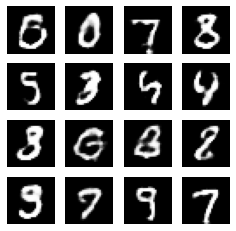

2200 [D loss supervised: 0.0024, acc.: 100.00%] [D loss unsupervised: 0.4700] [G loss: 1.564017]


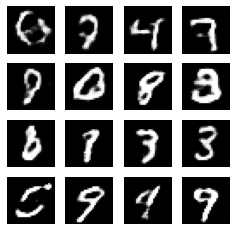

2300 [D loss supervised: 0.0031, acc.: 100.00%] [D loss unsupervised: 0.3315] [G loss: 2.059266]


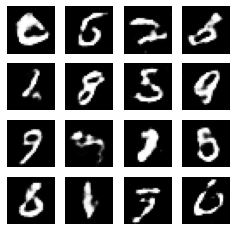

2400 [D loss supervised: 0.0020, acc.: 100.00%] [D loss unsupervised: 0.6191] [G loss: 1.416005]


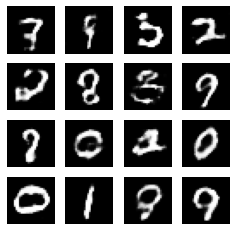

2500 [D loss supervised: 0.0032, acc.: 100.00%] [D loss unsupervised: 0.3709] [G loss: 1.777663]


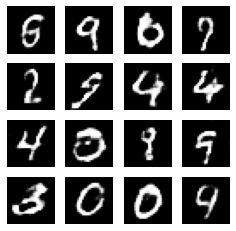

2600 [D loss supervised: 0.0034, acc.: 100.00%] [D loss unsupervised: 0.4035] [G loss: 2.369087]


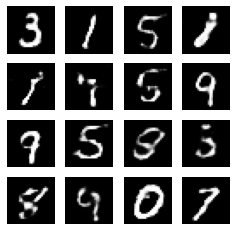

2700 [D loss supervised: 0.0007, acc.: 100.00%] [D loss unsupervised: 0.5294] [G loss: 1.740242]


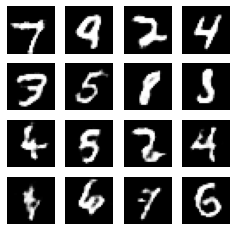

2800 [D loss supervised: 0.0022, acc.: 100.00%] [D loss unsupervised: 0.4417] [G loss: 1.992687]


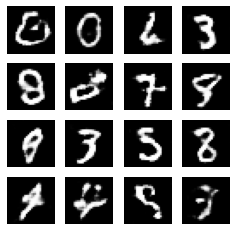

2900 [D loss supervised: 0.0127, acc.: 100.00%] [D loss unsupervised: 0.3954] [G loss: 2.481266]


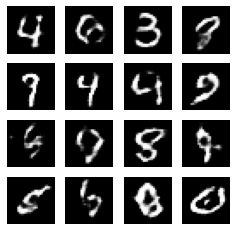

3000 [D loss supervised: 0.0030, acc.: 100.00%] [D loss unsupervised: 0.6938] [G loss: 1.900067]


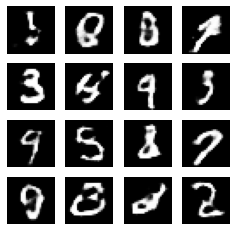

3100 [D loss supervised: 0.0015, acc.: 100.00%] [D loss unsupervised: 0.3645] [G loss: 1.930140]


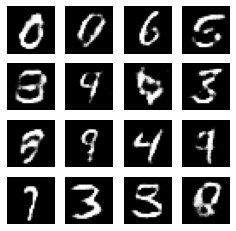

3200 [D loss supervised: 0.0027, acc.: 100.00%] [D loss unsupervised: 0.4968] [G loss: 1.970560]


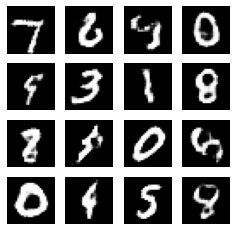

3300 [D loss supervised: 0.0015, acc.: 100.00%] [D loss unsupervised: 0.4960] [G loss: 1.521083]


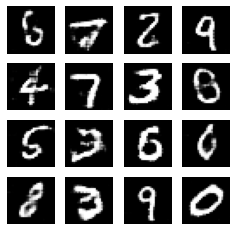

3400 [D loss supervised: 0.0050, acc.: 100.00%] [D loss unsupervised: 0.3923] [G loss: 1.839214]


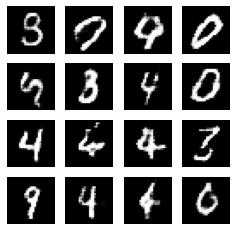

3500 [D loss supervised: 0.0007, acc.: 100.00%] [D loss unsupervised: 0.2647] [G loss: 2.509257]


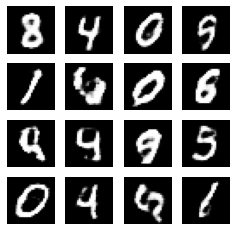

3600 [D loss supervised: 0.0018, acc.: 100.00%] [D loss unsupervised: 0.3512] [G loss: 2.116593]


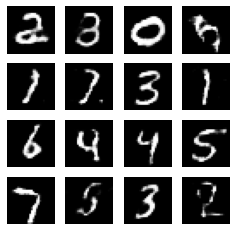

3700 [D loss supervised: 0.0002, acc.: 100.00%] [D loss unsupervised: 0.3341] [G loss: 1.682345]


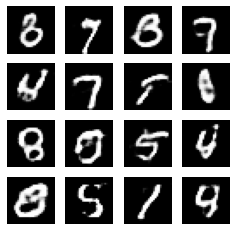

3800 [D loss supervised: 0.0014, acc.: 100.00%] [D loss unsupervised: 0.3687] [G loss: 2.654576]


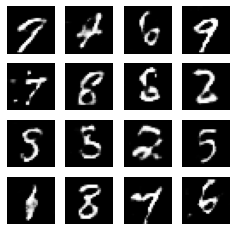

3900 [D loss supervised: 0.0008, acc.: 100.00%] [D loss unsupervised: 0.5195] [G loss: 3.010721]


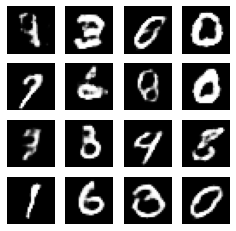

4000 [D loss supervised: 0.0013, acc.: 100.00%] [D loss unsupervised: 0.4441] [G loss: 2.387157]


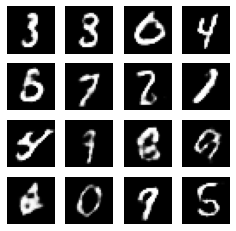

4100 [D loss supervised: 0.0003, acc.: 100.00%] [D loss unsupervised: 0.3586] [G loss: 1.794784]


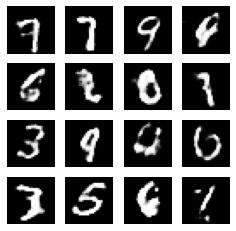

4200 [D loss supervised: 0.0012, acc.: 100.00%] [D loss unsupervised: 0.4204] [G loss: 2.657757]


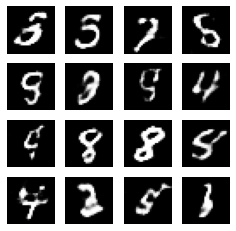

4300 [D loss supervised: 0.0020, acc.: 100.00%] [D loss unsupervised: 0.6894] [G loss: 2.775900]


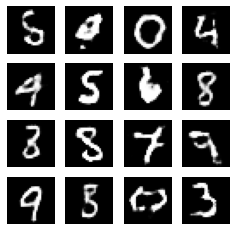

4400 [D loss supervised: 0.0012, acc.: 100.00%] [D loss unsupervised: 0.3862] [G loss: 2.203338]


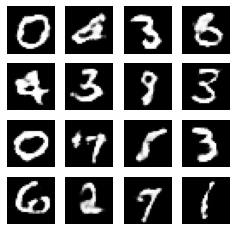

4500 [D loss supervised: 0.0005, acc.: 100.00%] [D loss unsupervised: 0.4695] [G loss: 2.076449]


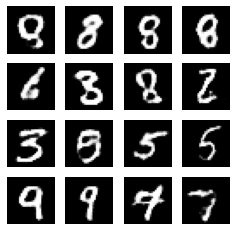

4600 [D loss supervised: 0.0012, acc.: 100.00%] [D loss unsupervised: 0.4422] [G loss: 1.990751]


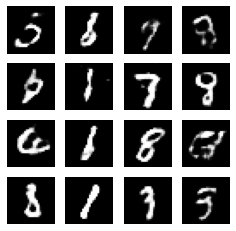

4700 [D loss supervised: 0.0003, acc.: 100.00%] [D loss unsupervised: 0.4441] [G loss: 1.843201]


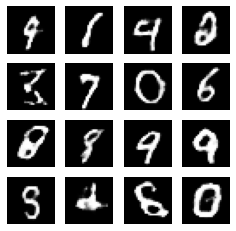

4800 [D loss supervised: 0.0004, acc.: 100.00%] [D loss unsupervised: 0.3791] [G loss: 1.820807]


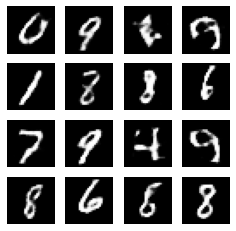

4900 [D loss supervised: 0.0028, acc.: 100.00%] [D loss unsupervised: 0.4489] [G loss: 1.618504]


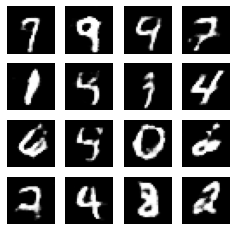

5000 [D loss supervised: 0.0003, acc.: 100.00%] [D loss unsupervised: 0.5121] [G loss: 1.739738]


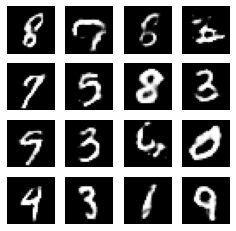

5100 [D loss supervised: 0.0001, acc.: 100.00%] [D loss unsupervised: 0.4280] [G loss: 1.974510]


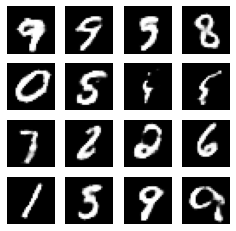

5200 [D loss supervised: 0.0006, acc.: 100.00%] [D loss unsupervised: 0.3660] [G loss: 1.757507]


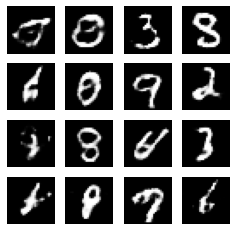

5300 [D loss supervised: 0.0004, acc.: 100.00%] [D loss unsupervised: 0.3879] [G loss: 2.196096]


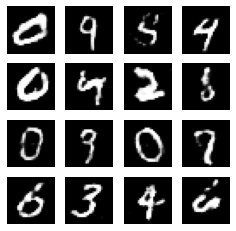

5400 [D loss supervised: 0.0011, acc.: 100.00%] [D loss unsupervised: 0.2961] [G loss: 2.513832]


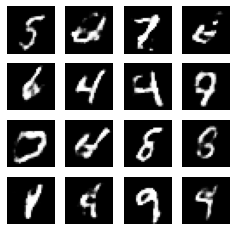

5500 [D loss supervised: 0.0001, acc.: 100.00%] [D loss unsupervised: 0.3109] [G loss: 1.788517]


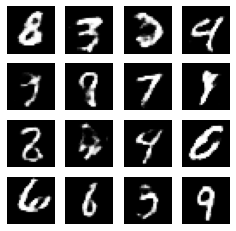

5600 [D loss supervised: 0.0004, acc.: 100.00%] [D loss unsupervised: 0.3642] [G loss: 2.065876]


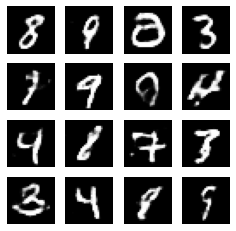

5700 [D loss supervised: 0.0003, acc.: 100.00%] [D loss unsupervised: 0.2535] [G loss: 2.423364]


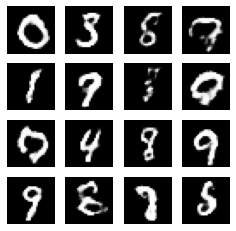

5800 [D loss supervised: 0.0054, acc.: 100.00%] [D loss unsupervised: 0.4529] [G loss: 2.701725]


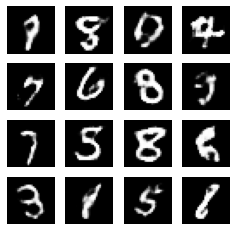

5900 [D loss supervised: 0.0001, acc.: 100.00%] [D loss unsupervised: 0.5051] [G loss: 2.776398]


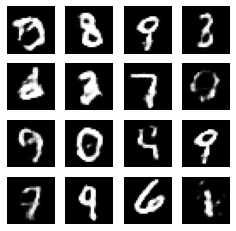

6000 [D loss supervised: 0.0018, acc.: 100.00%] [D loss unsupervised: 0.5067] [G loss: 2.370913]


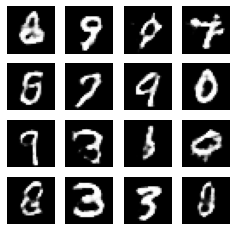

6100 [D loss supervised: 0.0002, acc.: 100.00%] [D loss unsupervised: 0.4587] [G loss: 2.287563]


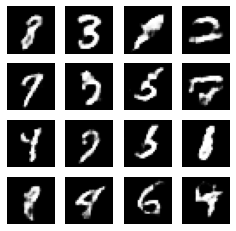

6200 [D loss supervised: 0.0002, acc.: 100.00%] [D loss unsupervised: 0.6299] [G loss: 2.549259]


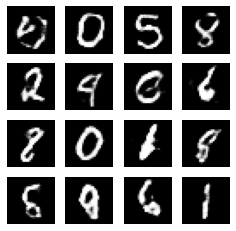

6300 [D loss supervised: 0.0006, acc.: 100.00%] [D loss unsupervised: 0.3745] [G loss: 2.768685]


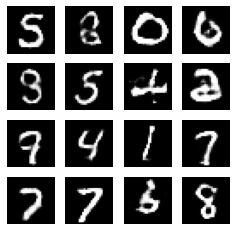

6400 [D loss supervised: 0.0003, acc.: 100.00%] [D loss unsupervised: 0.3730] [G loss: 2.041994]


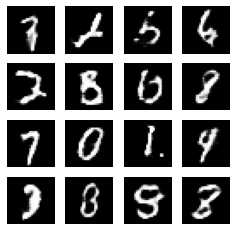

6500 [D loss supervised: 0.0003, acc.: 100.00%] [D loss unsupervised: 0.2772] [G loss: 2.661821]


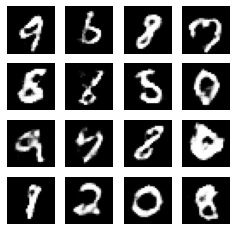

6600 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.3879] [G loss: 2.374595]


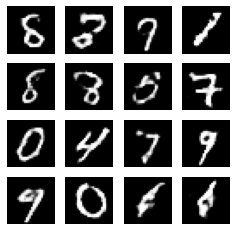

6700 [D loss supervised: 0.0001, acc.: 100.00%] [D loss unsupervised: 0.3577] [G loss: 3.871657]


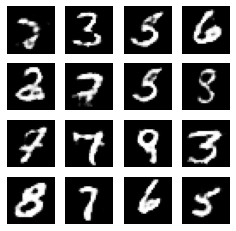

6800 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.2746] [G loss: 1.907909]


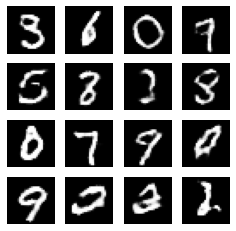

6900 [D loss supervised: 0.0001, acc.: 100.00%] [D loss unsupervised: 0.3350] [G loss: 2.522152]


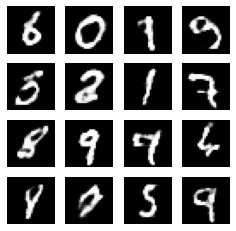

7000 [D loss supervised: 0.0005, acc.: 100.00%] [D loss unsupervised: 0.4441] [G loss: 1.901783]


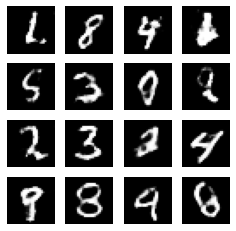

7100 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.4198] [G loss: 2.580956]


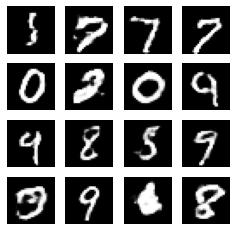

7200 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.3659] [G loss: 2.658038]


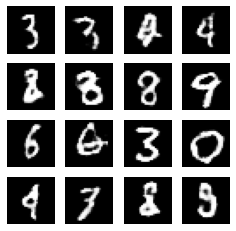

7300 [D loss supervised: 0.0002, acc.: 100.00%] [D loss unsupervised: 0.4148] [G loss: 3.012748]


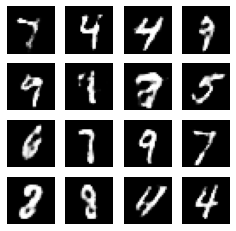

7400 [D loss supervised: 0.0001, acc.: 100.00%] [D loss unsupervised: 0.5966] [G loss: 2.387553]


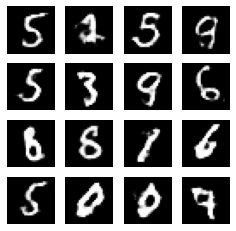

7500 [D loss supervised: 0.0001, acc.: 100.00%] [D loss unsupervised: 0.3874] [G loss: 2.817450]


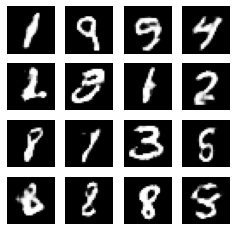

7600 [D loss supervised: 0.0008, acc.: 100.00%] [D loss unsupervised: 0.3456] [G loss: 2.799262]


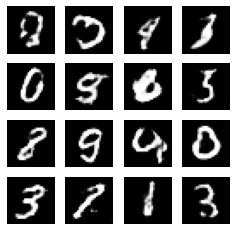

7700 [D loss supervised: 0.0001, acc.: 100.00%] [D loss unsupervised: 0.3689] [G loss: 2.237090]


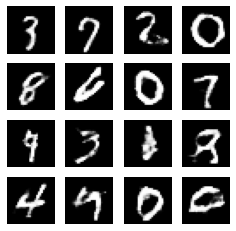

7800 [D loss supervised: 0.0002, acc.: 100.00%] [D loss unsupervised: 0.3963] [G loss: 3.506765]


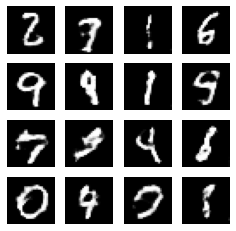

7900 [D loss supervised: 0.0001, acc.: 100.00%] [D loss unsupervised: 0.3555] [G loss: 1.831401]


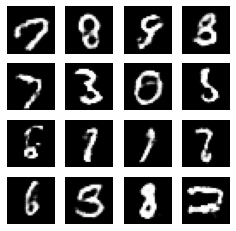

8000 [D loss supervised: 0.0000, acc.: 100.00%] [D loss unsupervised: 0.3125] [G loss: 2.423782]


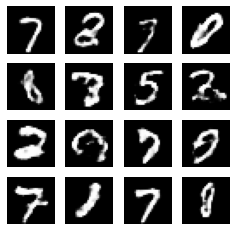

In [23]:
# 하이퍼파라미터를 셋팅합니다.
#iterations = 7000
iterations = 8000
batch_size = 25
sample_interval = 100

# 지정한 반복 횟수 동안 SGAN을 훈련합니다.
train(iterations, batch_size, sample_interval)

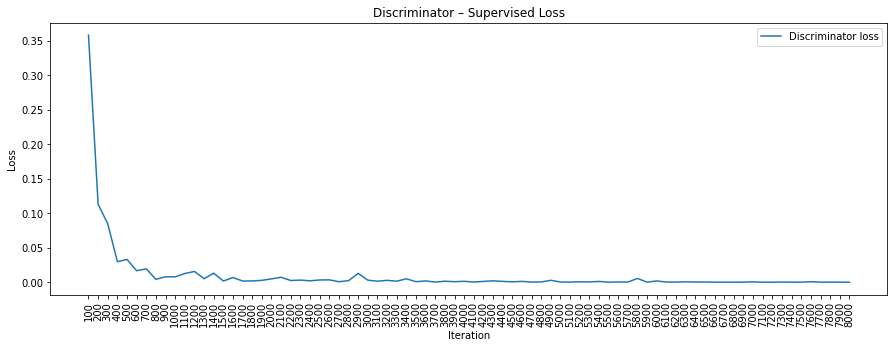

In [24]:
losses = np.array(supervised_losses)

# 판별자의 지도 학습 손실을 그립니다.
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses, label="Discriminator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Discriminator – Supervised Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

## SGAN classifier

In [25]:
x, y = dataset.training_set()
y = to_categorical(y, num_classes=num_classes)

# 훈련 세트에서 분류 정확도 계산
_, accuracy = discriminator_supervised.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

2/2 [==============================] - 0s 15ms/step - loss: 1.9407e-06 - accuracy: 1.0000
Training Accuracy: 100.00%


In [26]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

# 테스트 세트에서 분류 정확도 계산
_, accuracy = discriminator_supervised.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

313/313 [==============================] - 1s 3ms/step - loss: 0.3847 - accuracy: 0.8836
Test Accuracy: 88.36%


## SGAN multi label confusion matrix

In [84]:
from sklearn.metrics import confusion_matrix
x, y = dataset.test_set()
y_onehot = to_categorical(y, num_classes=num_classes)
pred_y_onehot = discriminator_supervised.predict(x)
pred_y = np.argmax(pred_y_onehot,axis=-1)
cf_matrix = confusion_matrix(y,pred_y, labels=list(range(10)))

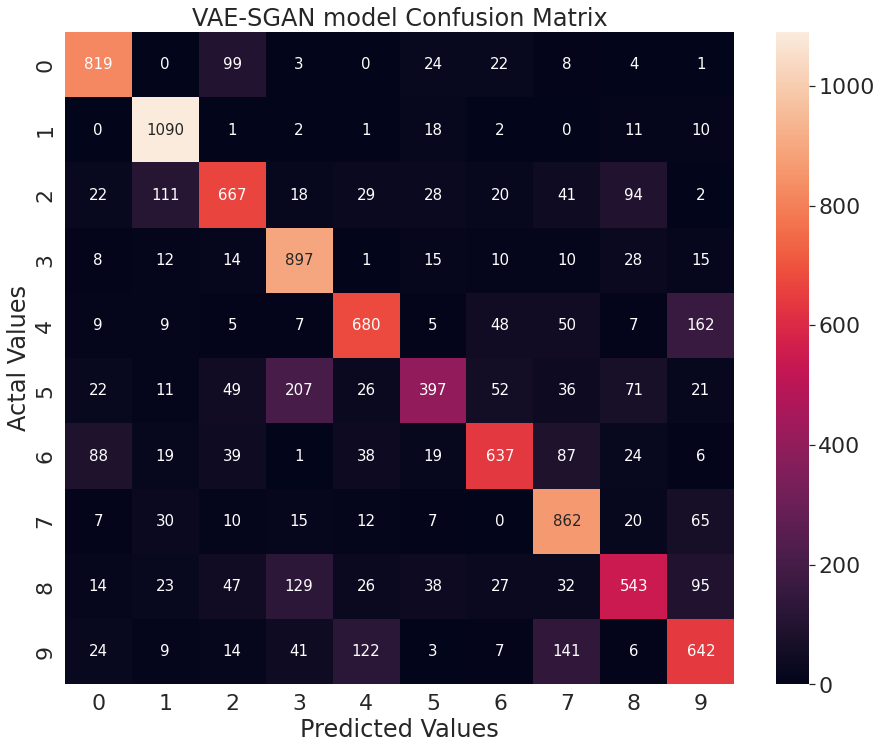

In [90]:
import seaborn as sns
cf_matrix_df = pd.DataFrame(cf_matrix,index = np.arange(10),columns=np.arange(10))
plt.figure(figsize = (15,12))
sns.heatmap(
    cf_matrix_df, annot=True,fmt='g',
    annot_kws = {'size':15}
)
plt.title('VAE-SGAN model Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

## Recall Precision F1 score

In [86]:
from sklearn.metrics import classification_report
SGAN_report = classification_report(y,pred_y,target_names=[f'{i}' for i in range(10)])
print(SGAN_report)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       980
           1       0.97      0.99      0.98      1135
           2       0.94      0.91      0.92      1032
           3       0.70      0.88      0.78      1010
           4       0.92      0.87      0.89       982
           5       0.86      0.54      0.67       892
           6       0.93      0.98      0.95       958
           7       0.94      0.87      0.90      1028
           8       0.83      0.91      0.87       974
           9       0.83      0.87      0.85      1009

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



## Normal Classifier

In [27]:
# SGAN 판별자와 같은 네트워크 구조를 가진 지도 학습 분류기
mnist_classifier = build_discriminator_supervised(build_discriminator_net(img_shape))
mnist_classifier.compile(loss='categorical_crossentropy',
                         metrics=['accuracy'],
                         optimizer=Adam())

  opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt)



In [28]:
imgs, labels = dataset.training_set()

# 레이블을 원-핫 인코딩합니다.
labels = to_categorical(labels, num_classes=num_classes)

# 분류기를 훈련합니다.
training = mnist_classifier.fit(x=imgs,
                                y=labels,
                                batch_size=32,
                                epochs=30,
                                verbose=1)
losses = training.history['loss']
accuracies = training.history['accuracy']

Epoch 1/30
2/2 [==============================] - 1s 67ms/step - loss: 2.3024 - accuracy: 0.0979
Epoch 2/30
2/2 [==============================] - 0s 8ms/step - loss: 2.2622 - accuracy: 0.2833
Epoch 3/30
2/2 [==============================] - 0s 8ms/step - loss: 2.2006 - accuracy: 0.2300
Epoch 4/30
2/2 [==============================] - 0s 8ms/step - loss: 2.0899 - accuracy: 0.2671
Epoch 5/30
2/2 [==============================] - 0s 8ms/step - loss: 1.9940 - accuracy: 0.2700
Epoch 6/30
2/2 [==============================] - 0s 8ms/step - loss: 1.8264 - accuracy: 0.4629
Epoch 7/30
2/2 [==============================] - 0s 9ms/step - loss: 1.6494 - accuracy: 0.5504
Epoch 8/30
2/2 [==============================] - 0s 8ms/step - loss: 1.3534 - accuracy: 0.7433
Epoch 9/30
2/2 [==============================] - 0s 8ms/step - loss: 1.1510 - accuracy: 0.7804
Epoch 10/30
2/2 [==============================] - 0s 8ms/step - loss: 0.9160 - accuracy: 0.7908
Epoch 11/30
2/2 [=====================

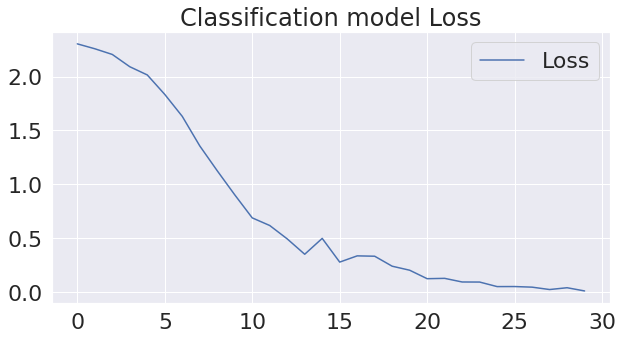

In [91]:
# 분류 손실을 그립니다
plt.figure(figsize=(10, 5))
plt.plot(np.array(losses), label="Loss")
plt.title("Classification model Loss")
plt.legend()
plt.show()

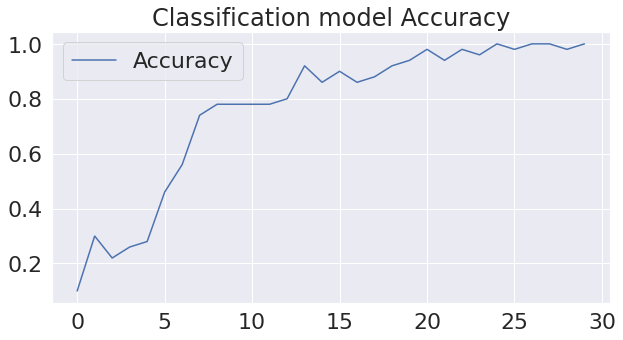

In [92]:
# 분류 정확도를 그립니다.
plt.figure(figsize=(10, 5))
plt.plot(np.array(accuracies), label="Accuracy")
plt.title("Classification model Accuracy")
plt.legend()
plt.show()

In [31]:
x, y = dataset.training_set()
y = to_categorical(y, num_classes=num_classes)

# 훈련 세트에 대한 분류 정확도를 계산합니다.
_, accuracy = mnist_classifier.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

2/2 [==============================] - 0s 3ms/step - loss: 0.0039 - accuracy: 1.0000
Training Accuracy: 100.00%


In [32]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

# 테스트 세트에 대한 분류 정확도를 계산합니다.
_, accuracy = mnist_classifier.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

313/313 [==============================] - 1s 4ms/step - loss: 1.2435 - accuracy: 0.7234
Test Accuracy: 72.34%


## CNN Classifier confusion matrix, scores

In [87]:
x, y = dataset.test_set()
y_onehot = to_categorical(y, num_classes=num_classes)
pred_y_onehot = mnist_classifier.predict(x)
pred_y = np.argmax(pred_y_onehot,axis=-1)
cf_matrix = confusion_matrix(y,pred_y, labels=list(range(10)))

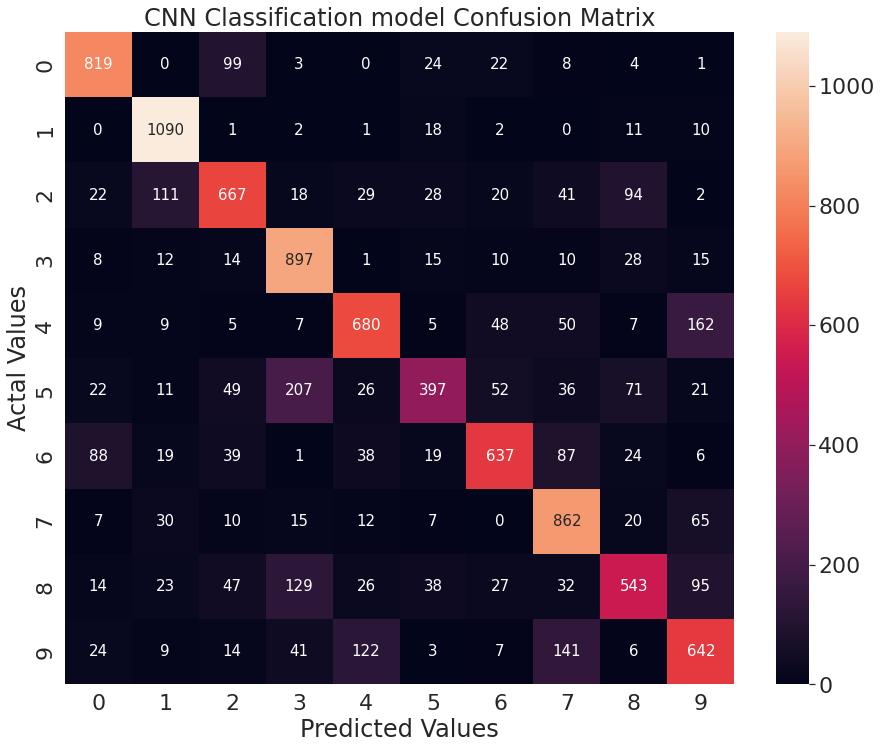

In [93]:
import seaborn as sns
cf_matrix_df = pd.DataFrame(cf_matrix,index = np.arange(10),columns=np.arange(10))
plt.figure(figsize = (15,12))
sns.heatmap(
    cf_matrix_df, annot=True,fmt='g',
    annot_kws = {'size':15}
)
plt.title('CNN Classification model Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [89]:
CNN_C_report = classification_report(y,pred_y,target_names=[f'{i}' for i in range(10)])
print(CNN_C_report)

              precision    recall  f1-score   support

           0       0.81      0.84      0.82       980
           1       0.83      0.96      0.89      1135
           2       0.71      0.65      0.67      1032
           3       0.68      0.89      0.77      1010
           4       0.73      0.69      0.71       982
           5       0.72      0.45      0.55       892
           6       0.77      0.66      0.71       958
           7       0.68      0.84      0.75      1028
           8       0.67      0.56      0.61       974
           9       0.63      0.64      0.63      1009

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.71     10000
weighted avg       0.72      0.72      0.72     10000

